### Imports

In [15]:
# Imports

# standard stuff
import pandas as pd
import numpy as np
from collections import Counter
import os
# Binn stuff
from binn import Network
from binn import BINN
from binn import BINNExplainer
# from the github of the binn
from util_for_examples import fit_data_matrix_to_network_input, generate_data
# our custom functions for training and testing
from cust_functions import training as trg
# torch stuff
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# Sklearn stuff
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

### Get Data

In [16]:
# Import covid data
covid_train = pd.read_csv('covid_data/covid_train_qm.csv', index_col=0)
covid_test = pd.read_csv('covid_data/covid_test_qm.csv', index_col=0)

covid_train_design = pd.read_csv('covid_data/covid_train_design_qm.csv', index_col=0)
covid_test_design = pd.read_csv('covid_data/covid_test_design_qm.csv', index_col=0)
covid_train_design["group"]+=1
covid_test_design["group"]+=1
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")

In [17]:
#### Import aki data

# Get data, we have to tranform it first
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# split into test and train according to paper
tm_p19_cols = [col for col in input_data_qm.columns if col.startswith("TM_P19")]
tm_m2012_cols = [col for col in input_data_qm.columns if col.startswith("TM_M2012")]

# Create train/test input based on these columns
test_input_data = input_data_qm[tm_p19_cols]
train_input_data = input_data_qm[tm_m2012_cols]
first_column = input_data_qm.iloc[:, 0]
train_input_data.insert(0, first_column.name, first_column)
test_input_data.insert(0, first_column.name, first_column)

#design_matrix
tm_m2012 = design_matrix['sample'].str.startswith("TM_M2012")
tm_p19 = design_matrix['sample'].str.startswith("TM_P19")
# Use the mask to create the separate DataFrames
test_design_matrix = design_matrix[tm_p19]
train_design_matrix = design_matrix[tm_m2012]

### AKI
- We perform 5-fold-CV

In [21]:
# 5 fold CV

# We first create an X tensor and a y tensor for the Corss validation. For this we create network/binn and make our x,y data so it fits the required input format
############# start of data creation ################
network = Network(
    input_data    =   train_input_data, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True
    )
binn = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

# Given functions to make the data network compatible
protein_matrix = fit_data_matrix_to_network_input(train_input_data, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=train_design_matrix)
# Change to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int16)

################ end of data creation ################

# Place where we store the data
model_save_dir = "trained_models/AKI_BINN"
os.makedirs(model_save_dir, exist_ok=True)

# cross validation 5-times
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# we dont need more epochs 30 sufficient
num_epochs = 30
fold = 0
results = {}

for train_index, val_index in kf.split(X_tensor):
    fold += 1
    print(f"Starting fold {fold}")
    
    # Initialize a new network each fold
    network = Network(
    input_data    =   input_data_qm, # use the preprocessed data
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", # This is the default value
    source_column = "child", # defined by our pathways-file
    target_column = "parent",
    subset_pathways = True # This is the default value
    )
    # Initate binn_aki for AKI
    binn_aki = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

    # train/ validation split
    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]
    # tensors
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val) 
    # Load the data according to binn documentation
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)
    # get the opitmizer according to binn documentation
    optimizer = binn_aki.configure_optimizers()[0][0]
    
    # results dict
    results[fold] = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], "train_f1_macro":  [], "val_f1_macro":  [], "train_roc_auc": [], "val_roc_auc": [],
                     'train_f1_phen1': [], 'train_f1_phen2': [], 'train_recall_phen1': [], 'train_recall_phen2': [], 'train_precision_phen1': [], 'train_precision_phen2': [],
                     'val_f1_phen1': [], 'val_f1_phen2': [], 'val_recall_phen1': [], 'val_recall_phen2': [], 'val_precision_phen1': [], 'val_precision_phen2': [],"val_cm":[]
                     }
    # for best epoch needed later for plotting results
    best_val_loss = np.inf
    best_epoch = -1
    best_model_state = None
    # train the binn
    for epoch in range(num_epochs):
        # Training
        binn_aki.train()
        total_loss = 0.0
        total_accuracy = 0

        train_true_labels = []
        train_predictions = []

        val_true_labels = []  
        val_predictions = []

        for inputs, targets in train_loader:
            inputs = inputs.to(binn_aki.device)
            targets = targets.to(binn_aki.device).type(torch.LongTensor)
            optimizer.zero_grad()
            outputs = binn_aki(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)
            train_true_labels.append(targets.cpu().numpy())
            train_predictions.append(outputs.cpu().detach().numpy())  
        # get things for roc and cm
        train_true_labels = np.concatenate(train_true_labels)
        train_logits = np.concatenate(train_predictions, axis=0)
        train_probs = torch.softmax(torch.tensor(train_logits), dim=1).numpy()  # Assuming binary classification
        train_roc_auc = roc_auc_score(train_true_labels, train_probs[:, 1])
        train_pred_labels = np.argmax(train_probs, axis=1)
        
        # Get the metrics#########
        train_cm = confusion_matrix(train_true_labels, train_pred_labels)
        train_metrics = trg.calculate_metrics(train_cm)
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = train_metrics
        # loss and accuracy
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        # add results
        results[fold]['train_loss'].append(avg_loss)
        results[fold]['train_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['train_f1_macro'].append(f1_macro)
        results[fold]['train_roc_auc'].append(train_roc_auc)
        results[fold]['train_f1_phen1'].append(f1_phen1)
        results[fold]['train_f1_phen2'].append(f1_phen2)
        results[fold]['train_recall_phen1'].append(recall_phen1)
        results[fold]['train_recall_phen2'].append(recall_phen2)
        results[fold]['train_precision_phen1'].append(precision_phen1)
        results[fold]['train_precision_phen2'].append(precision_phen2)
        # Prints
        print(f'Epoch {epoch}, Training Average Accuracy {avg_accuracy}, Average Loss: {avg_loss}')

        #### start of  Validation ####
        binn_aki.eval()
        val_loss = 0.0
        val_accuracy = 0
        # evaluate
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(binn_aki.device)
                targets = targets.to(binn_aki.device).type(torch.LongTensor)
                outputs = binn_aki(inputs)
                loss = F.cross_entropy(outputs, targets)
                val_loss += loss.item()
                val_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)
                val_true_labels.append(targets.cpu().numpy())
                val_predictions.append(outputs.cpu().detach().numpy())  
        # roc and cm stuff and other metric stuff
        val_true_labels = np.concatenate(val_true_labels)
        val_logits = np.concatenate(val_predictions, axis=0)
        val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()  # Assuming binary classification
        val_roc_auc = roc_auc_score(val_true_labels, val_probs[:, 1])
        val_pred_labels = np.argmax(val_probs, axis=1)
        val_cm = confusion_matrix(val_true_labels, val_pred_labels)
        val_metrics = trg.calculate_metrics(val_cm) 
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macr = val_metrics       
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        # prints
        print(f'Epoch {epoch}, Validation Average Accuracy {avg_val_accuracy}, Average Loss: {avg_val_loss}')
        
        # get results
        results[fold]['val_loss'].append(avg_val_loss)
        results[fold]['val_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['val_f1_macro'].append(f1_macr)
        results[fold]['val_roc_auc'].append(val_roc_auc)
        results[fold]['val_f1_phen1'].append(f1_phen1)
        results[fold]['val_f1_phen2'].append(f1_phen2)
        results[fold]['val_recall_phen1'].append(recall_phen1)
        results[fold]['val_recall_phen2'].append(recall_phen2)
        results[fold]['val_precision_phen1'].append(precision_phen1)
        results[fold]['val_precision_phen2'].append(precision_phen2)
        results[fold]['val_cm'].append(val_cm)
        # best model stuff
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = binn_aki.state_dict().copy()

    if best_model_state is not None:
        model_save_path = os.path.join(model_save_dir, f"best_model_fold_{fold}.pth")
        torch.save(best_model_state, model_save_path)
    results[fold]['best_val_epoch'] = best_epoch
    # Safe the 5 models in the folder
    model_save_path = os.path.join(model_save_dir, f"model_fold_{fold}.pth")
    torch.save(binn_aki.state_dict(), model_save_path)

    print(f"Model saved for fold {fold} at {model_save_path}")


BINN is on the device: cpu
dasdf
Starting fold 1

BINN is on the device: cpu
Epoch 0, Training Average Accuracy 0.625, Average Loss: 0.6710938683577946
Epoch 0, Validation Average Accuracy 0.5833333134651184, Average Loss: 0.688206136226654
Epoch 1, Training Average Accuracy 0.6696428656578064, Average Loss: 0.5965936545814786
Epoch 1, Validation Average Accuracy 0.5833333134651184, Average Loss: 0.6838879187901815
Epoch 2, Training Average Accuracy 0.7053571343421936, Average Loss: 0.5402929357119969
Epoch 2, Validation Average Accuracy 0.5416666865348816, Average Loss: 0.6541733543078104
Epoch 3, Training Average Accuracy 0.75, Average Loss: 0.5115800627640316
Epoch 3, Validation Average Accuracy 0.7083333134651184, Average Loss: 0.5229528347651163
Epoch 4, Training Average Accuracy 0.8392857313156128, Average Loss: 0.36102742914642605
Epoch 4, Validation Average Accuracy 0.7916666865348816, Average Loss: 0.4361938287814458
Epoch 5, Training Average Accuracy 0.9107142686843872, Aver

### Print metrics and scors

Average validation accuracy: 0.983 +/- 0.02
Average validation roc_auc: 1.0 +/- 0.0
Average validation f1_macro: 0.983 +/- 0.02
Average validation f1_phen1: 0.983 +/- 0.02
Average validation f1_phen2: 0.983 +/- 0.02
Average validation recall_phen1: 0.982 +/- 0.04
Average validation recall_phen2: 0.982 +/- 0.04
Average validation precision_phen1: 0.986 +/- 0.03
Average validation precision_phen2: 0.986 +/- 0.03


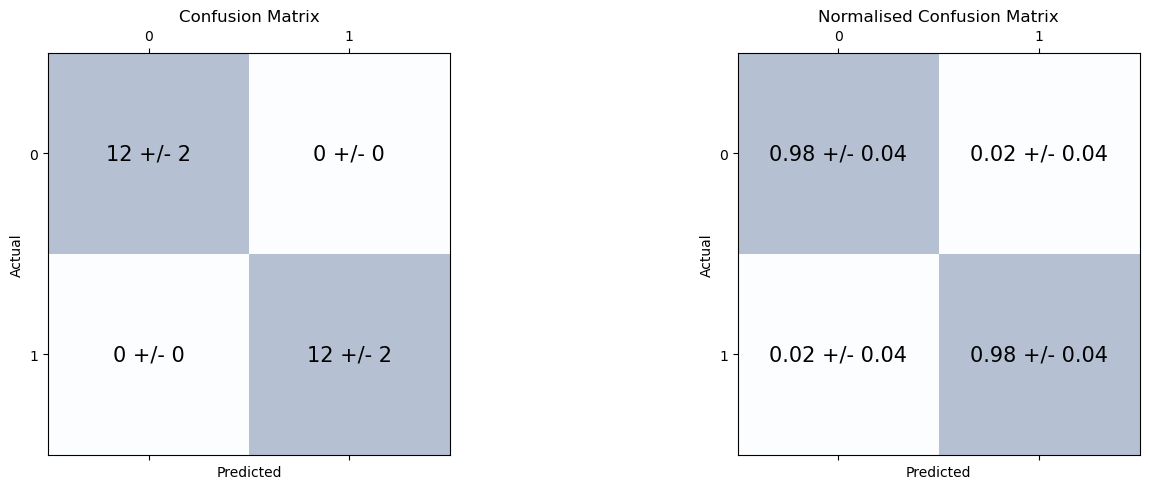

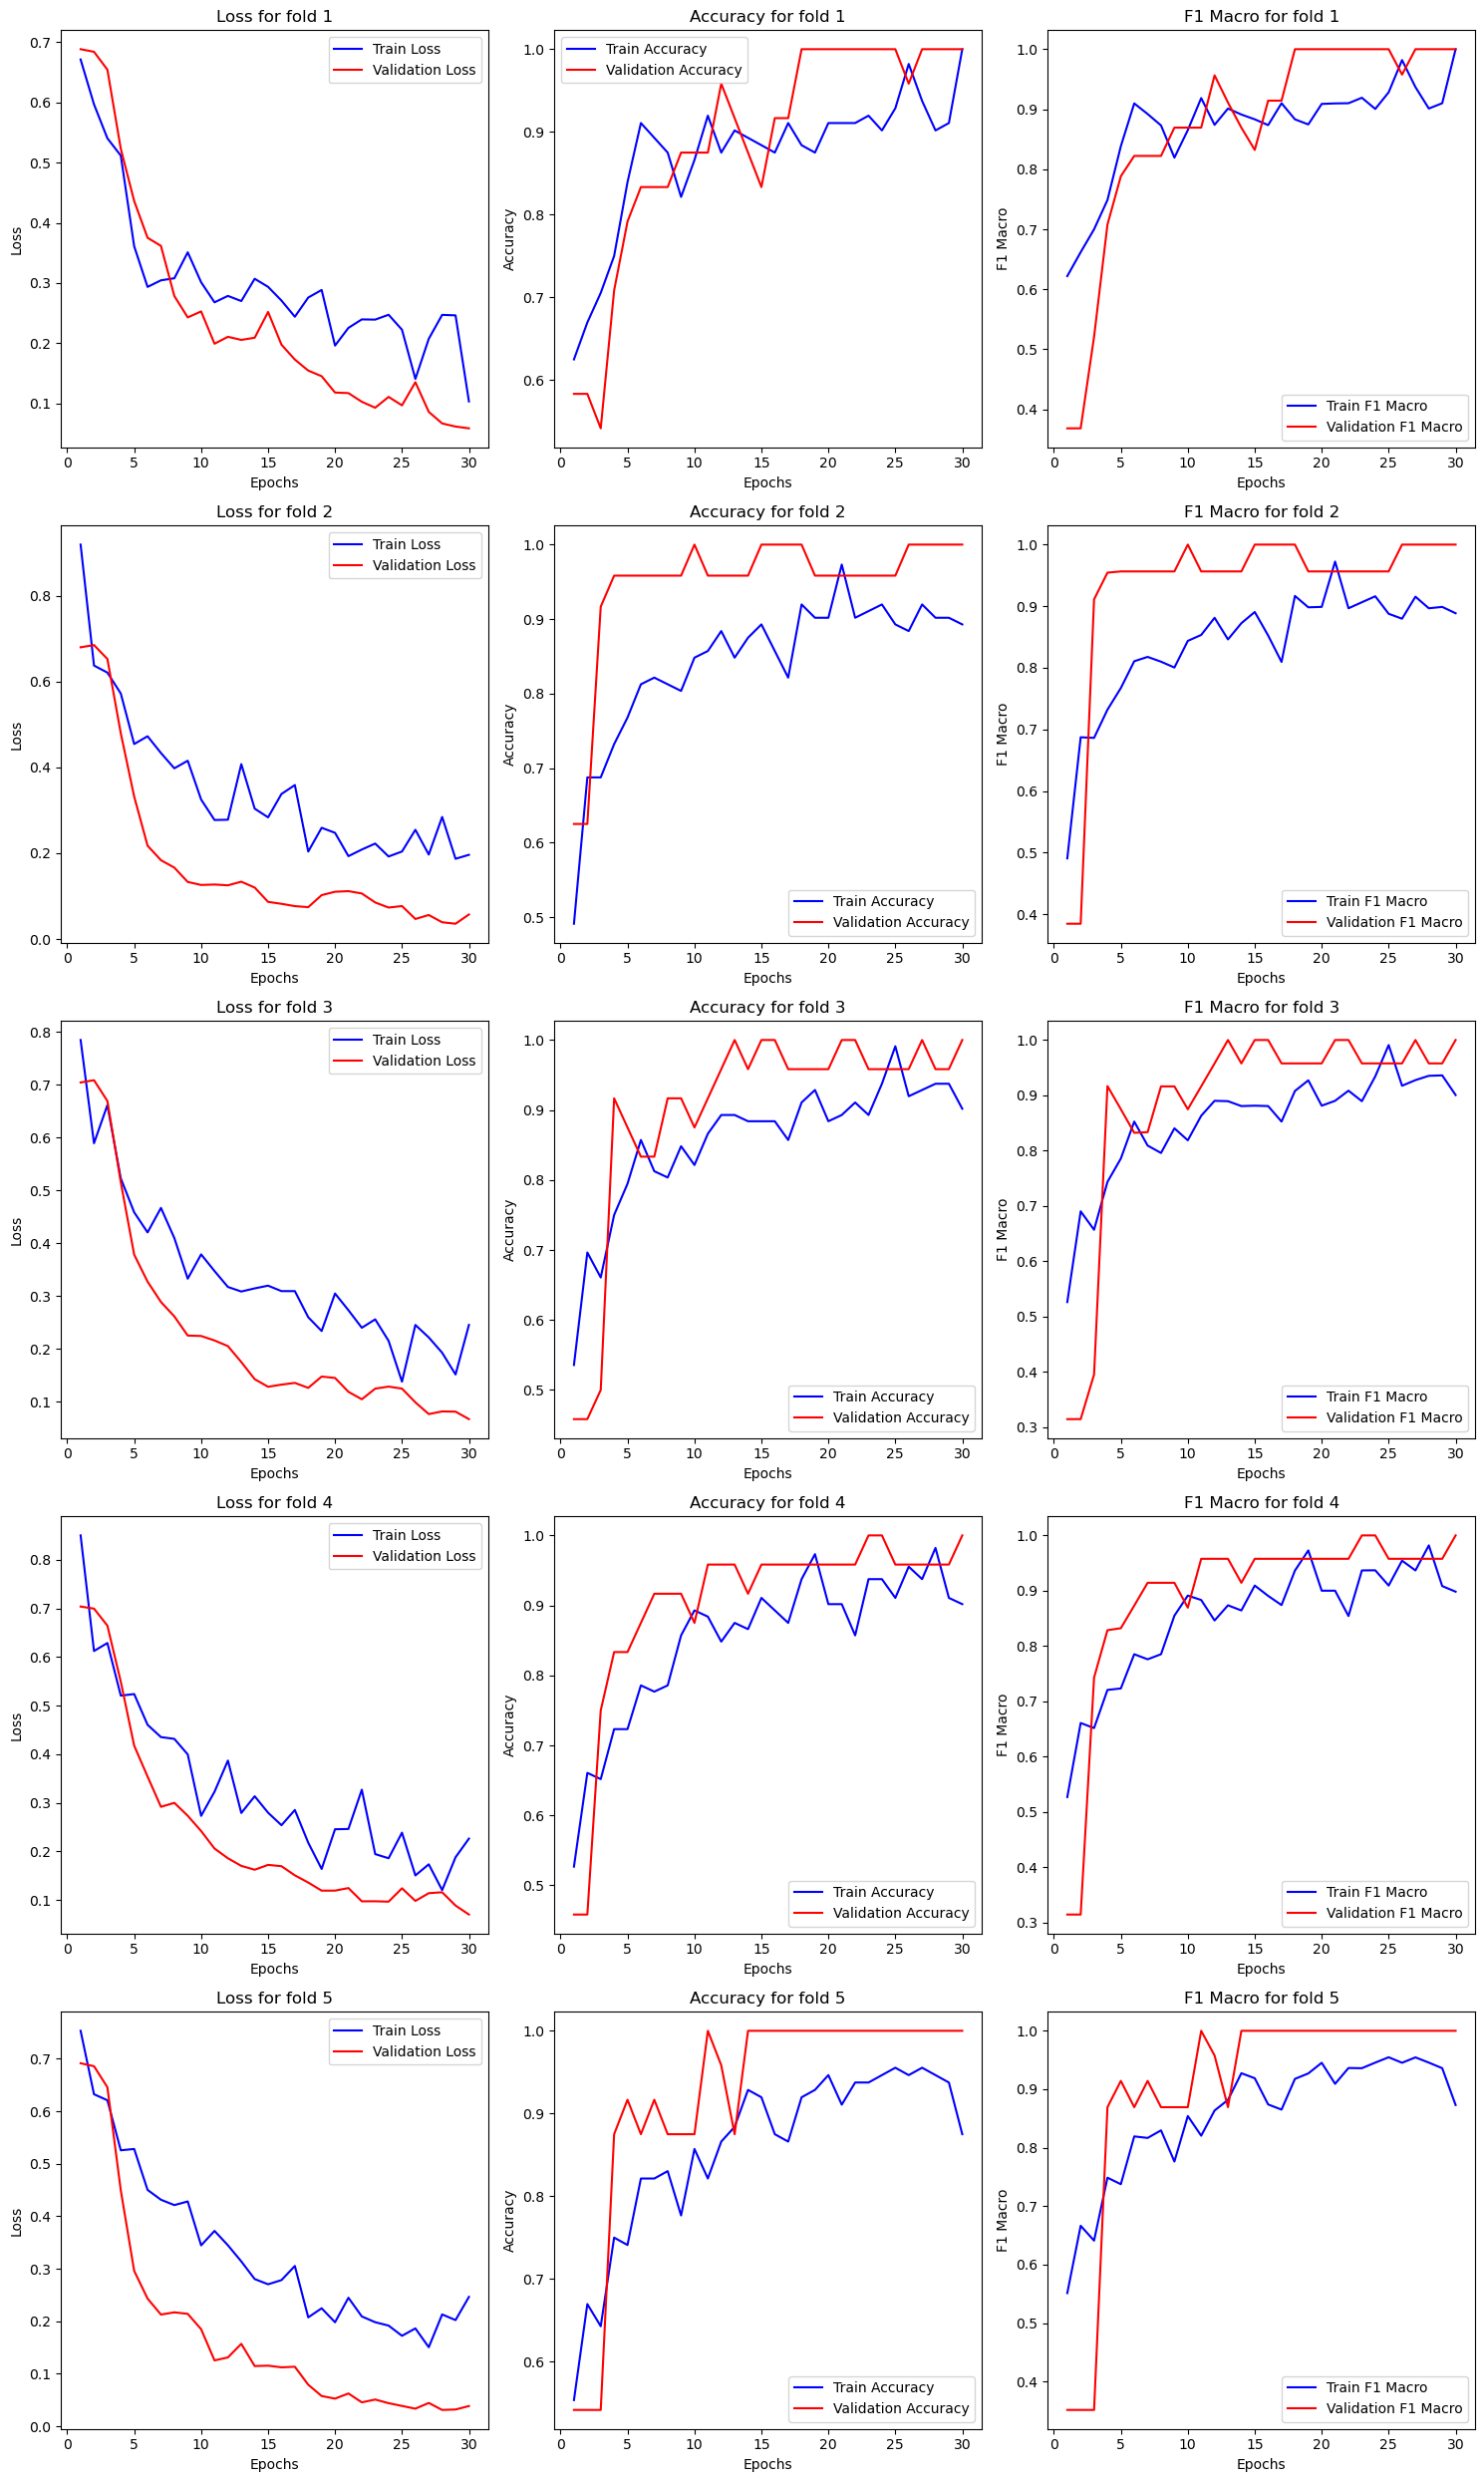

In [22]:
trg.print_val_results(results)
trg.plot_confusion_matrix(results)
trg.plot_results(results, 5)

### Testing of the AKI data

dasdf
Test Accuracy: 0.8980
Test ROC_AUC: 0.9286
Test F1 Macro: 0.8858
Test F1 Phen1: 0.9231
Test F1 Phen2: 0.8485
Test Recall Phen1: 0.8571
Test Recall Phen2: 1.0000


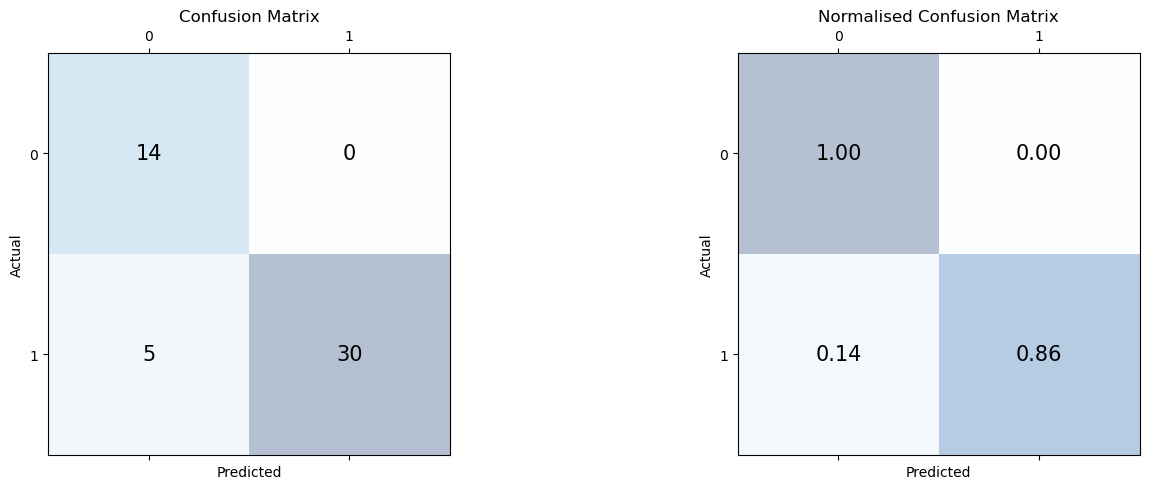

In [23]:
# Test

num_folds = 5  
model_save_dir = "trained_models/AKI_BINN"  

# Load test data analogue to the train part
protein_matrix_test = fit_data_matrix_to_network_input(test_input_data, features=network.inputs)
X_test, y_test = generate_data(protein_matrix_test, design_matrix=test_design_matrix)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # tryout long instead of int16
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8)  # Adjust batch size as needed

# get the predictions
all_predictions = []

# We go through each of the 5 cv models and get the predictions
for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn_aki 
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(binn_aki.device)

    fold_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(binn_aki.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_predictions.extend(predicted.cpu().numpy())

    all_predictions.append(fold_predictions)


all_predictions = list(map(list, zip(*all_predictions)))
# majority voting
majority_votes = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in all_predictions]

# accuracy
y_test = y_test_tensor.numpy()  # Convert to numpy if it's a tensor
correct = sum(1 for true, pred in zip(y_test, majority_votes) if true == pred)
accuracy = 100 * correct / len(y_test)

# cm, roc and other metrics
test_confusion_matrix = confusion_matrix(y_test, majority_votes, labels=[0, 1])

test_roc_auc = roc_auc_score(y_test, majority_votes)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = trg.calculate_metrics(test_confusion_matrix)



# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
trg.plot_confusion_matrix(test_confusion_matrix, use = 'test')

### Interpreting the BINN

- We will use explain all 5 CV model seperataly and average, this is somewhat similar to the binn documentation to robustness and the binn.explain_average except that we dont explain the same model 5 times but explain the 5 CV and average over them

In [30]:
# Interpreting
network = Network(
    input_data    =   train_input_data, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
binn = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

protein_matrix = fit_data_matrix_to_network_input(train_input_data, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=train_design_matrix)

num_folds = 5  
model_save_dir = "trained_models/AKI_BINN"  
explanations = []

test_data = torch.tensor(X, dtype=torch.float32)
background_data = torch.tensor(X, dtype=torch.float32)

for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn 
    model.load_state_dict(torch.load(model_path)) 
    model.eval()

    explainer = BINNExplainer(model)
    importance_df = explainer.explain(test_data, background_data)
    explanations.append(importance_df)



BINN is on the device: cpu
dasdf


In [31]:
### This is done in a similar ways as in the binn documentation example so the data has the same format

# Prepare the data to be explained
concatenated_values = pd.DataFrame()

for i in range(len(explanations) - 1):
    value_column = explanations[i]['value'].rename(f'value{i}')
    concatenated_values = pd.concat([concatenated_values, value_column], axis=1)

df = explanations[-1]

for column in concatenated_values.columns:
    df.insert(loc=df.columns.get_loc('value'), column=column, value=concatenated_values[column])

df.rename(columns={'value': 'value4'}, inplace=True)

df['value_mean'] = df[['value0', 'value1', 'value2', 'value3', 'value4']].mean(axis=1)
df['values_std'] = df[['value0', 'value1', 'value2', 'value3', 'value4']].std(axis=1)

df['value'] = df['value_mean']

# Drop if the source == target, aka the pathways/protein explains itself
df["copy"] = df.apply(lambda x: True if x["source name"] == x["target name"] else False, axis=1)
df = df[df["copy"] == False]

In [33]:
# Returns a df with mean = mean rank -> lower better
# Code from the binn documentation
importance_df_copy = df.groupby(["source name", "source layer", "target layer"], as_index=False).mean(numeric_only=True)
mean_ranks = []
std_ranks = []
source_layer = []
sources = []
for layer in range(binn.n_layers):
    layer_df = importance_df_copy[importance_df_copy["source layer"] == layer].copy()
    for i in range(5):
        layer_df.sort_values(f"value{i}", ascending=False, inplace=True)
        layer_df[f"rank_{i}"] = range(len(layer_df.index))
    rank_cols = [c for c in layer_df.columns if c.startswith("rank")]
    mean_ranks += (layer_df[rank_cols].mean(axis=1)/ len(layer_df.index)).tolist()
    sources += layer_df["source name"].tolist()
    std_ranks  += (layer_df[rank_cols].std(axis=1)/ len(layer_df.index)).tolist()
    source_layer += layer_df["source layer"].tolist()
plot_df = pd.DataFrame({"mean":mean_ranks, "std":std_ranks, "source layer":source_layer, "source":sources})
plot_df.sort_values("mean").head(20)

,mean,std,source layer,source
0,0.003118,0.003378,0,P04114
450,0.004560,0.003714,1,R-HSA-140534
2,0.006236,0.010375,0,P04908
3,0.008018,0.008274,0,P02647
758,0.008494,0.005727,2,R-HSA-5357769
10,0.009354,0.007454,0,P60709
7,0.012027,0.002988,0,P08571
1,0.012472,0.011202,0,Q96A08
1017,0.015517,0.007213,3,R-HSA-109581
459,0.023453,0.018769,1,R-HSA-114608


### Covid
- we train 5-fold-cv
- The code is the same as for the AKI only the data is different!!!!

In [34]:
### Training with k=5 CV
# Initiate network

# Same as in the AKI just different data
network = Network(
    input_data    =   covid_train, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
binn = BINN(
    network=network,
    n_layers=4,
    dropout=0.2,
    validate=False,
    residual=False,
    device="cpu",
    learning_rate=0.001
)

protein_matrix = fit_data_matrix_to_network_input(covid_train, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=covid_train_design)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int16)

model_save_dir = "trained_models/Covid_BINN"
os.makedirs(model_save_dir, exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

num_epochs = 30
fold = 0
results = {}

for train_index, val_index in kf.split(X_tensor):
    fold += 1
    print(f"Starting fold {fold}")
    
    network = Network(
    input_data    =   covid_train, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein",
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
    binn_covid = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)

    optimizer = binn_covid.configure_optimizers()[0][0]
    
    # results dict
    results[fold] = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], "train_f1_macro":  [], "val_f1_macro":  [], "train_roc_auc": [], "val_roc_auc": [],
                     'train_f1_phen1': [], 'train_f1_phen2': [], 'train_recall_phen1': [], 'train_recall_phen2': [], 'train_precision_phen1': [], 'train_precision_phen2': [],
                     'val_f1_phen1': [], 'val_f1_phen2': [], 'val_recall_phen1': [], 'val_recall_phen2': [], 'val_precision_phen1': [], 'val_precision_phen2': [],"val_cm":[]
                     }
    # for best epoch needed later for plotting results
    best_val_loss = np.inf
    best_epoch = -1
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        binn_covid.train()
        total_loss = 0.0
        total_accuracy = 0

        train_true_labels = []
        train_predictions = []

        val_true_labels = []
        val_predictions = []

        for inputs, targets in train_loader:
            inputs = inputs.to(binn_covid.device)
            targets = targets.to(binn_covid.device).type(torch.LongTensor)
            optimizer.zero_grad()
            outputs = binn_covid(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)

            train_true_labels.append(targets.cpu().numpy())
            train_predictions.append(outputs.cpu().detach().numpy())  

        train_true_labels = np.concatenate(train_true_labels)
        train_logits = np.concatenate(train_predictions, axis=0)
        train_probs = torch.softmax(torch.tensor(train_logits), dim=1).numpy()  # Assuming binary classification
        train_roc_auc = roc_auc_score(train_true_labels, train_probs[:, 1])
        
        train_pred_labels = np.argmax(train_probs, axis=1)
        

        # Get the metrics
        train_cm = confusion_matrix(train_true_labels, train_pred_labels)
        train_metrics = trg.calculate_metrics(train_cm)
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = train_metrics
        # loss and accuracy
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        # add results
        results[fold]['train_loss'].append(avg_loss)
        results[fold]['train_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['train_f1_macro'].append(f1_macro)
        results[fold]['train_roc_auc'].append(train_roc_auc)
        results[fold]['train_f1_phen1'].append(f1_phen1)
        results[fold]['train_f1_phen2'].append(f1_phen2)
        results[fold]['train_recall_phen1'].append(recall_phen1)
        results[fold]['train_recall_phen2'].append(recall_phen2)
        results[fold]['train_precision_phen1'].append(precision_phen1)
        results[fold]['train_precision_phen2'].append(precision_phen2)
        #############
        
        print(f'Epoch {epoch}, Training Average Accuracy {avg_accuracy}, Average Loss: {avg_loss}')

        # Validation
        binn_covid.eval()
        val_loss = 0.0
        val_accuracy = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(binn_covid.device)
                targets = targets.to(binn_covid.device).type(torch.LongTensor)
                outputs = binn_covid(inputs)
                loss = F.cross_entropy(outputs, targets)
                val_loss += loss.item()
                val_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)

                val_true_labels.append(targets.cpu().numpy())
                val_predictions.append(outputs.cpu().detach().numpy())  

        val_true_labels = np.concatenate(val_true_labels)
        val_logits = np.concatenate(val_predictions, axis=0)
        val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()  # Assuming binary classification
        val_roc_auc = roc_auc_score(val_true_labels, val_probs[:, 1])
        
        val_pred_labels = np.argmax(val_probs, axis=1)
        val_cm = confusion_matrix(val_true_labels, val_pred_labels)
        val_metrics = trg.calculate_metrics(val_cm) 
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macr = val_metrics       
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        print(f'Epoch {epoch}, Validation Average Accuracy {avg_val_accuracy}, Average Loss: {avg_val_loss}')
        
        # validation
        results[fold]['val_loss'].append(avg_val_loss)
        results[fold]['val_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['val_f1_macro'].append(f1_macr)
        results[fold]['val_roc_auc'].append(val_roc_auc)
        results[fold]['val_f1_phen1'].append(f1_phen1)
        results[fold]['val_f1_phen2'].append(f1_phen2)
        results[fold]['val_recall_phen1'].append(recall_phen1)
        results[fold]['val_recall_phen2'].append(recall_phen2)
        results[fold]['val_precision_phen1'].append(precision_phen1)
        results[fold]['val_precision_phen2'].append(precision_phen2)
        results[fold]['val_cm'].append(val_cm)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = binn_covid.state_dict().copy()

    if best_model_state is not None:
        model_save_path = os.path.join(model_save_dir, f"best_model_fold_{fold}.pth")
        torch.save(best_model_state, model_save_path)
    results[fold]['best_val_epoch'] = best_epoch
    # Safe the 5 models in the folder
    model_save_path = os.path.join(model_save_dir, f"model_fold_{fold}.pth")
    torch.save(binn_covid.state_dict(), model_save_path)

    print(f"Model saved for fold {fold} at {model_save_path}")


BINN is on the device: cpu
dasdf
Starting fold 1

BINN is on the device: cpu
Epoch 0, Training Average Accuracy 0.6232143044471741, Average Loss: 0.6652298544134413
Epoch 0, Validation Average Accuracy 0.779411792755127, Average Loss: 0.5242256995509652
Epoch 1, Training Average Accuracy 0.7178571224212646, Average Loss: 0.5660371980496816
Epoch 1, Validation Average Accuracy 0.8308823704719543, Average Loss: 0.3992438211160548
Epoch 2, Training Average Accuracy 0.7285714149475098, Average Loss: 0.5409155879701887
Epoch 2, Validation Average Accuracy 0.845588207244873, Average Loss: 0.37692562446874733
Epoch 3, Training Average Accuracy 0.7732142806053162, Average Loss: 0.4836348525115422
Epoch 3, Validation Average Accuracy 0.845588207244873, Average Loss: 0.37102047836079316
Epoch 4, Training Average Accuracy 0.7660714387893677, Average Loss: 0.4901095096554075
Epoch 4, Validation Average Accuracy 0.845588207244873, Average Loss: 0.3723988313885296
Epoch 5, Training Average Accuracy

Average validation accuracy: 0.875 +/- 0.02
Average validation roc_auc: 0.956 +/- 0.01
Average validation f1_macro: 0.873 +/- 0.02
Average validation f1_phen1: 0.883 +/- 0.03
Average validation f1_phen2: 0.863 +/- 0.02
Average validation recall_phen1: 0.905 +/- 0.02
Average validation recall_phen2: 0.842 +/- 0.04
Average validation precision_phen1: 0.864 +/- 0.05
Average validation precision_phen2: 0.887 +/- 0.02


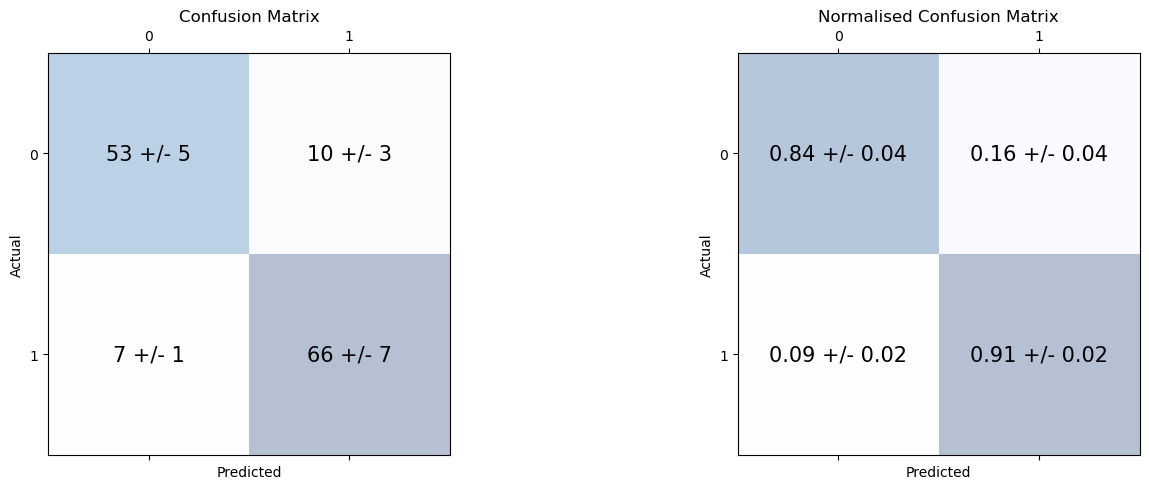

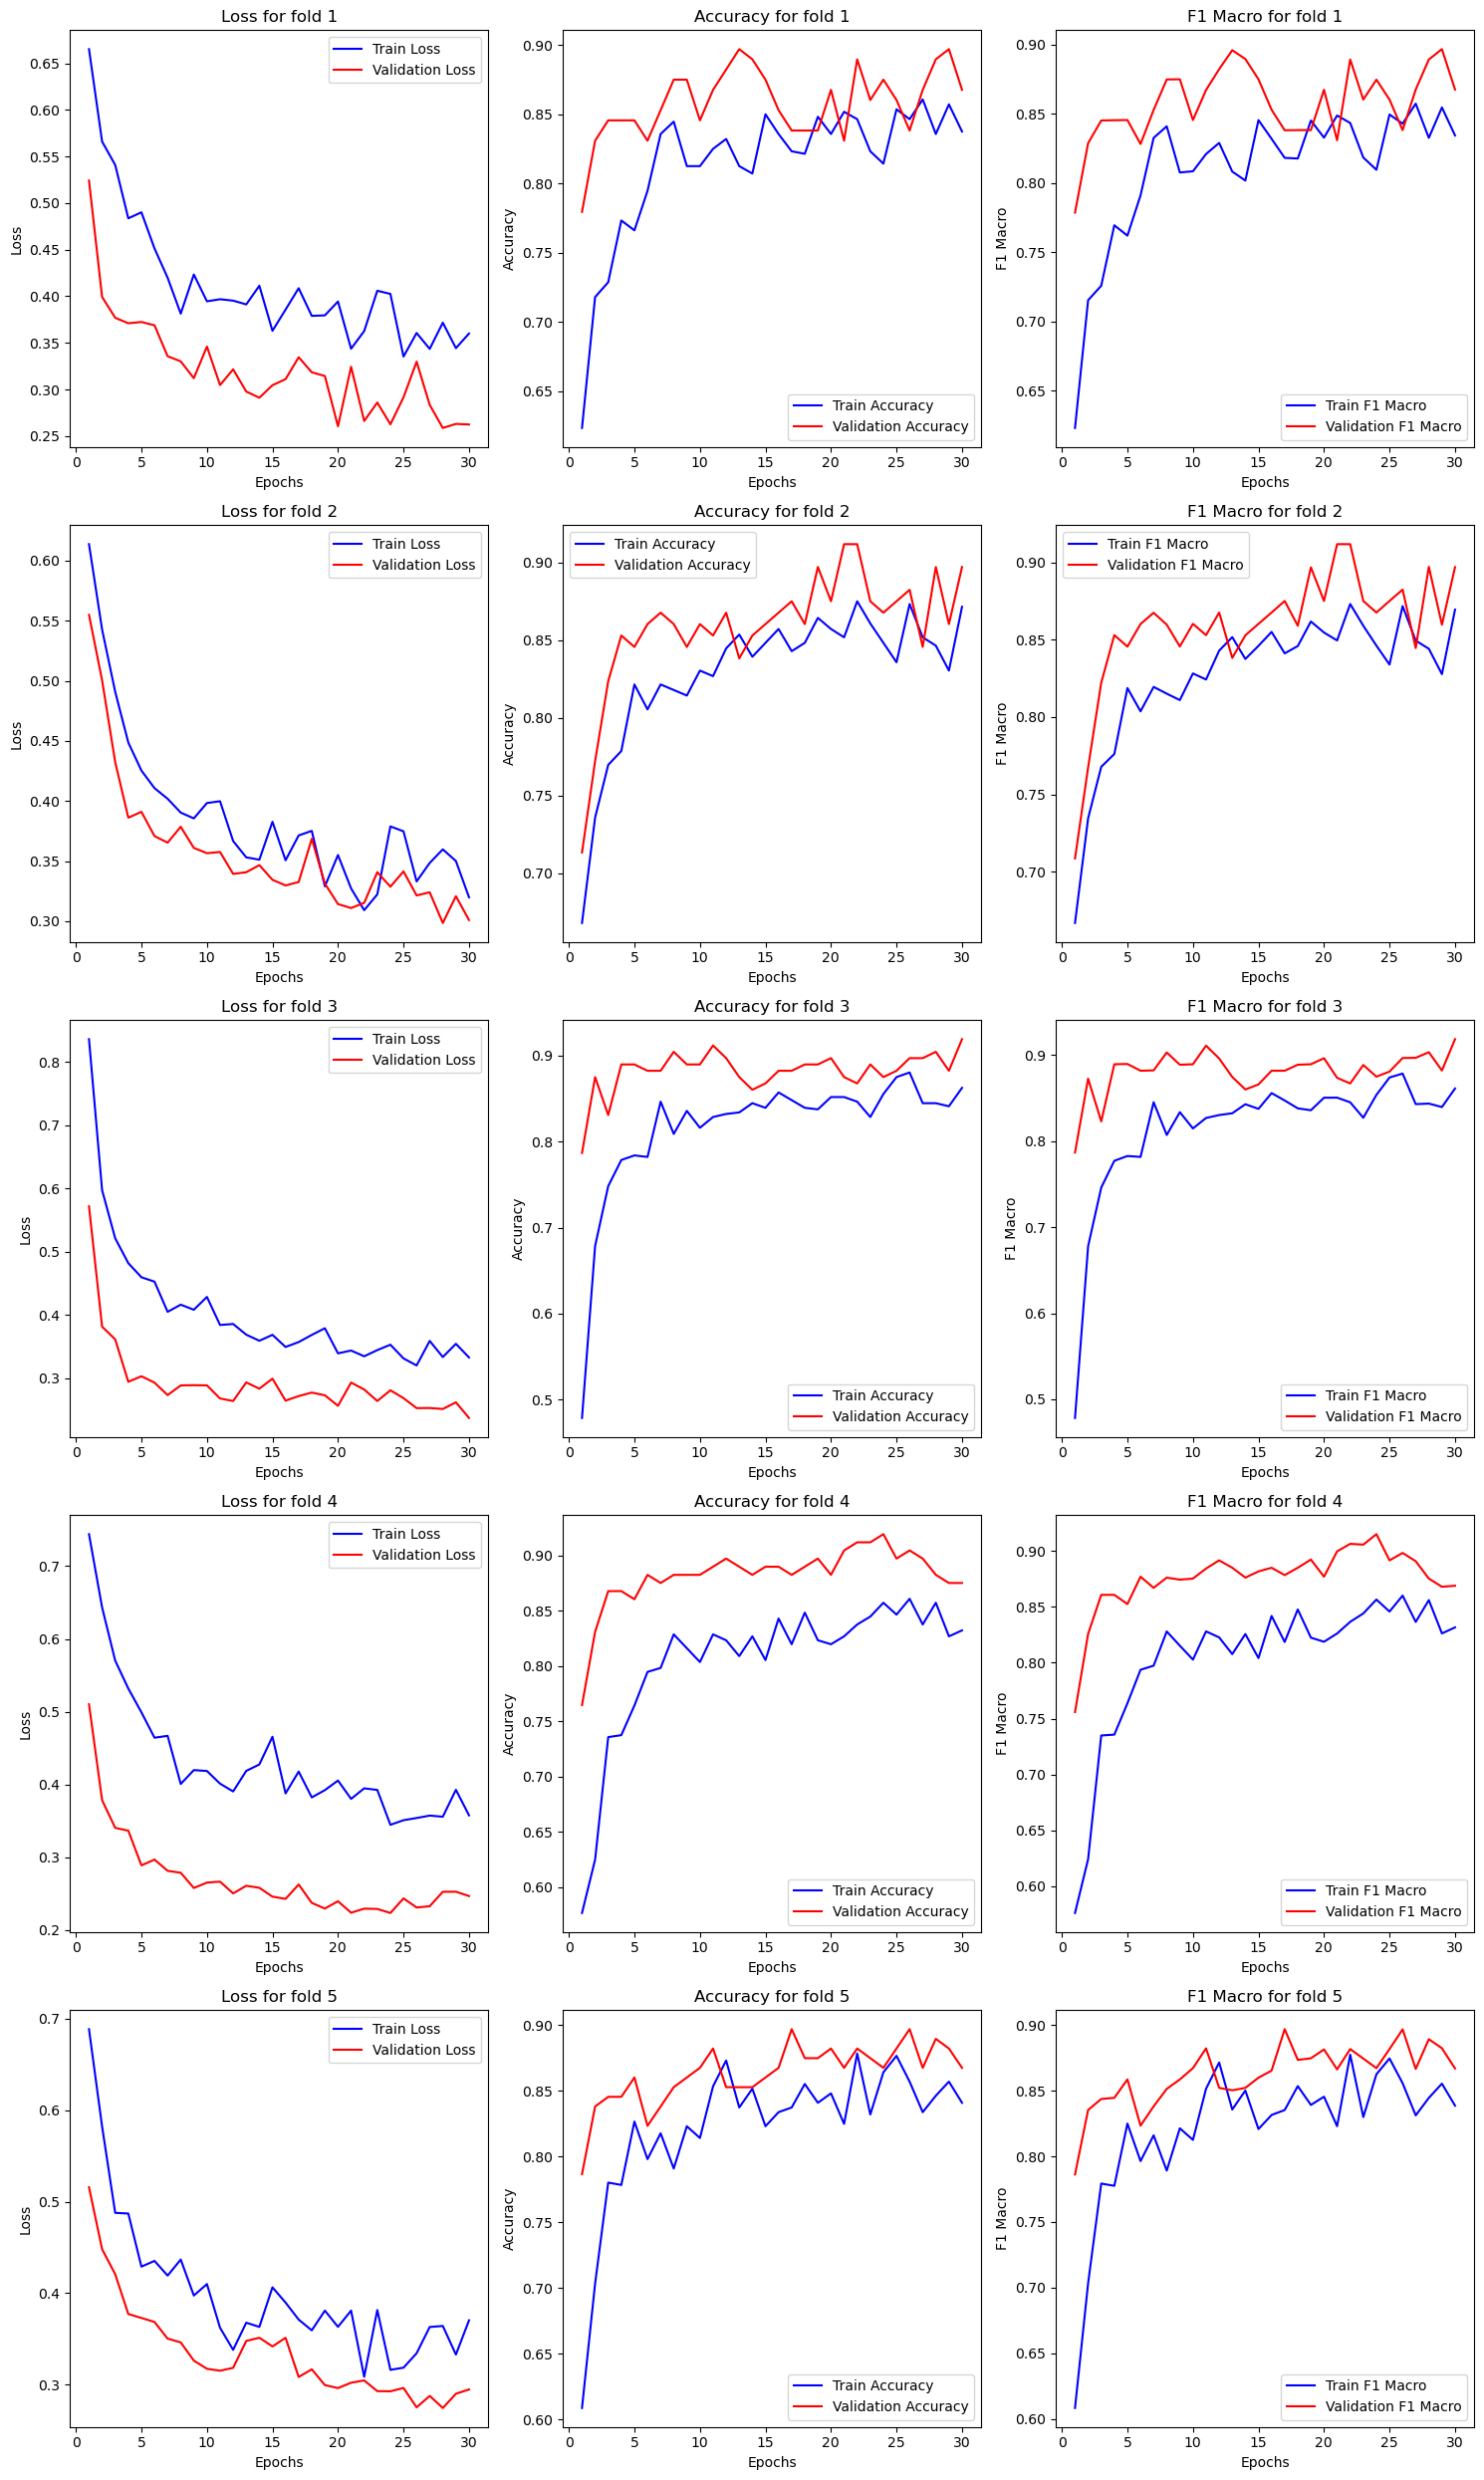

In [35]:
trg.print_val_results(results)
trg.plot_confusion_matrix(results)
trg.plot_results(results, 5)

### Test Covid data

dasdf
Test Accuracy: 0.8481
Test ROC_AUC: 0.8469
Test F1 Macro: 0.8475
Test F1 Phen1: 0.8571
Test F1 Phen2: 0.8378
Test Recall Phen1: 0.8780
Test Recall Phen2: 0.8158


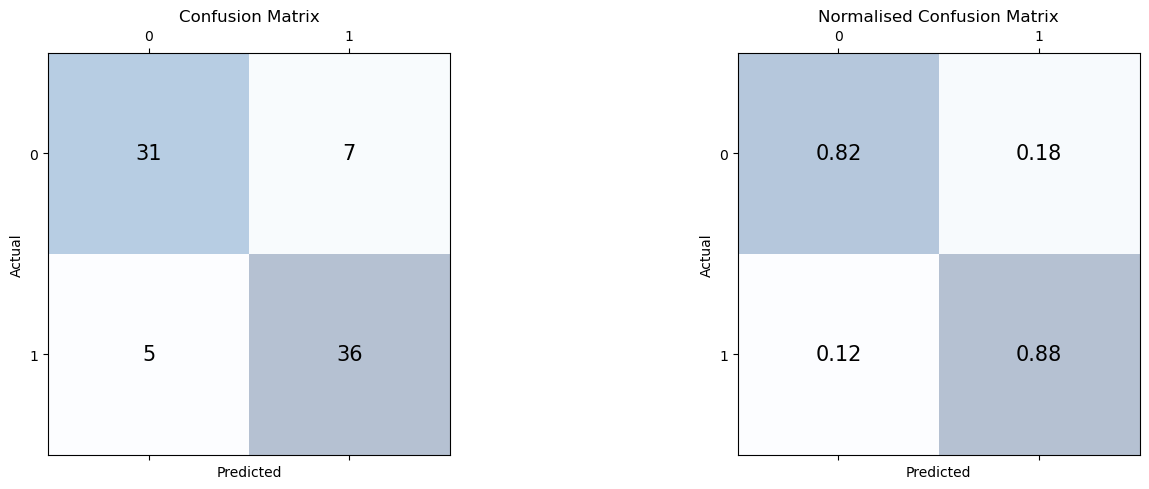

In [36]:
num_folds = 5  
model_save_dir = "trained_models/Covid_BINN" 

# Load test data
protein_matrix_test = fit_data_matrix_to_network_input(covid_test, features=network.inputs)
X_test, y_test = generate_data(protein_matrix_test, design_matrix=covid_test_design)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8)  

all_predictions = []

# go through each of the 5 models
for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn_covid 
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(binn_covid.device)  

    fold_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(binn_covid.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_predictions.extend(predicted.cpu().numpy())

    all_predictions.append(fold_predictions)

all_predictions = list(map(list, zip(*all_predictions)))
majority_votes = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in all_predictions]

# Calculate accuracy
y_test = y_test_tensor.numpy()  # Convert to numpy if it's a tensor
correct = sum(1 for true, pred in zip(y_test, majority_votes) if true == pred)
accuracy = 100 * correct / len(y_test)


test_confusion_matrix = confusion_matrix(y_test, majority_votes, labels=[0, 1])

test_roc_auc = roc_auc_score(y_test, majority_votes)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = trg.calculate_metrics(test_confusion_matrix)



# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
trg.plot_confusion_matrix(test_confusion_matrix, use = 'test')

### Interpreting Covid

In [38]:
network = Network(
    input_data    =   covid_train, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
binn = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

protein_matrix = fit_data_matrix_to_network_input(covid_train, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=covid_train_design)

num_folds = 5  
model_save_dir = "trained_models/Covid_BINN"  
explanations = []

test_data = torch.tensor(X, dtype=torch.float32)
background_data = torch.tensor(X, dtype=torch.float32)

for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn 
    model.load_state_dict(torch.load(model_path)) 
    model.eval()

    explainer = BINNExplainer(model)
    importance_df = explainer.explain(test_data, background_data)
    explanations.append(importance_df)



BINN is on the device: cpu
dasdf


In [39]:
# Merge the df
concatenated_values = pd.DataFrame()

for i in range(len(explanations) - 1):
    value_column = explanations[i]['value'].rename(f'value{i}')
    concatenated_values = pd.concat([concatenated_values, value_column], axis=1)

df = explanations[-1]

for column in concatenated_values.columns:
    df.insert(loc=df.columns.get_loc('value'), column=column, value=concatenated_values[column])

df.rename(columns={'value': 'value4'}, inplace=True)
#last_df = last_df.iloc[:, :-5]

df['value_mean'] = df[['value0', 'value1', 'value2', 'value3', 'value4']].mean(axis=1)
df['values_std'] = df[['value0', 'value1', 'value2', 'value3', 'value4']].std(axis=1)

df['value'] = df['value_mean']


# Drop if the source == target, aka the pathways/protein explains itself
df["copy"] = df.apply(lambda x: True if x["source name"] == x["target name"] else False, axis=1)
df = df[df["copy"] == False]


In [40]:
importance_df_copy = df.groupby(["source name", "source layer", "target layer"], as_index=False).mean(numeric_only=True)
mean_ranks = []
std_ranks = []
source_layer = []
sources = []
for layer in range(binn.n_layers):
    layer_df = importance_df_copy[importance_df_copy["source layer"] == layer].copy()
    for i in range(5):
        layer_df.sort_values(f"value{i}", ascending=False, inplace=True)
        layer_df[f"rank_{i}"] = range(len(layer_df.index))
    rank_cols = [c for c in layer_df.columns if c.startswith("rank")]
    mean_ranks += (layer_df[rank_cols].mean(axis=1)/ len(layer_df.index)).tolist()
    sources += layer_df["source name"].tolist()
    std_ranks  += (layer_df[rank_cols].std(axis=1)/ len(layer_df.index)).tolist()
    source_layer += layer_df["source layer"].tolist()
plot_df = pd.DataFrame({"mean":mean_ranks, "std":std_ranks, "source layer":source_layer, "source":sources})
plot_df.sort_values("mean").head(20)

,mean,std,source layer,source
293,0.000000,0.000000,3,R-HSA-168249
126,0.004494,0.006154,1,R-HSA-114608
0,0.009600,0.013145,0,P02649
1,0.016000,0.016000,0,P06396
4,0.022400,0.008764,0,P02675
131,0.024719,0.026825,1,R-HSA-111465
216,0.025316,0.020014,2,R-HSA-76005
2,0.028800,0.019267,0,P02671
214,0.032911,0.041599,2,R-HSA-166658
294,0.036667,0.029814,3,R-HSA-2173782
